# Kaplan-Meier Survival Curves
**Tables/Figures**: Figure 5

This notebook generates K-M Survival curves for the 5 largest PROACT clusters

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *

import joblib
import matplotlib
import matplotlib.pyplot as plt
from string import ascii_lowercase
from pathlib import Path

from lifelines.plotting import add_at_risk_counts
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import itertools
from statsmodels.stats.multitest import fdrcorrection

In [3]:
# Formatting params
pd.set_option('display.max_columns', 26)

col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']
parameters = {'pdf.fonttype':42,
            'ps.fonttype':42,
            'font.sans-serif':['Arial'],
            'axes.labelsize': 30,
            'xtick.labelsize':30,
            'ytick.labelsize':30,
            'legend.fontsize':35,
            'figure.subplot.hspace':0.2,
            'figure.subplot.wspace':0.3}
plt.rcParams.update(parameters)

In [4]:
def calc_surv_km(k, model, data, df_stat, duration_col, event_col):
    """Calculate Kaplan-Meier curve for given cluster"""
    k_idx = (np.where(model.z == k)[0]) 
    idx_patid = [data['SI'][x] for x in k_idx]
    cur_stat = df_stat.loc[idx_patid].dropna(subset=[duration_col, event_col], how='any')
    if (cur_stat.shape[0])>1:
        kmf = KaplanMeierFitter()
        clust_duration = cur_stat[duration_col]
        clust_event = cur_stat[event_col]
        kfit = kmf.fit(clust_duration, clust_event)
    else:
#         print(k, 'err')
        kfit, clust_duration, clust_event = 'err', 'err', 'err'
    return kfit, clust_duration, clust_event
    

def get_km_counts(kfit, tick_labs):
    """Get K-M at-risk, censored, events counts"""
    df_event_table = pd.DataFrame(columns=['Time', 'At Risk', 'Censored', 'Known Deaths'])
    for tick in tick_labs:
        event_table_slice = (
                        kfit.event_table.assign(at_risk=lambda x: x.at_risk - x.removed)
                        .loc[:tick, ["at_risk", "censored", "observed"]]
                        .agg({"at_risk": "min", "censored": "sum", "observed": "sum"})
                        .rename({"at_risk": "At Risk", "censored": "Censored", "observed": "Known Deaths"})
                    )
        event_table_slice['Time']=tick
        df_event_table = df_event_table.append(event_table_slice, ignore_index=True)
    return df_event_table


def calculate_logrank(events_dict, clust_i, clust_j):
    """Calculate logrank test for two clusters, given events_dict"""
    dur_col = 'disease_duration'
    ev_col = 'death_event'
    
    results = logrank_test(events_dict[clust_i][0], events_dict[clust_j][0], event_observed_A=events_dict[clust_i][1], event_observed_B=events_dict[clust_j][1],)
    return results.p_value

In [5]:
def pairwise_logrank(cluster_dict):
    '''Calculate pairwise logrank test between all cluster combinations in cluster dict'''
    comb = list(itertools.combinations(cluster_dict.keys(),2))
    comb_out = []
    for pair in comb:
        cur_p = calculate_logrank(cluster_dict, pair[0], pair[1])
        comb_out.append(cur_p)
        
    rej, p_adj = fdrcorrection(comb_out)
    print('% of clusters that are different with logrank test: {}'.format(100*sum(rej)/len(comb_out)))
    
    return rej, p_adj

## Figure 5: K-M curves and at-risk table

In [6]:
# Load death data file
df_stat_death = pd.read_csv('data/processed_data/static_proact_death.csv', index_col='subj_proj_id')

In [7]:
# Select best MAP model
exp_path = Path('data/model_data/1_alsfrsr_all')

cur_proj = 'proact'
cur_model_path = exp_path / 'results' / 'rbf'
cur_data_path = exp_path / 'data_{}_min3_alsfrst.pkl'.format(cur_proj)

cur_model_suffix = 'model_{}_min3_alsfrst'.format(cur_proj)
cur_model = get_map_model(cur_model_path, cur_model_suffix, num_seeds=5)
cur_data = joblib.load(cur_data_path)

seed did not pass monotonicity test: 3
seed did not pass monotonicity test: 4
best seed: 2, ll -3853.8510614331317


Cluster a Median Survival: 6.08
Cluster b Median Survival: inf
Cluster c Median Survival: inf
Cluster d Median Survival: 2.90
Cluster e Median Survival: inf


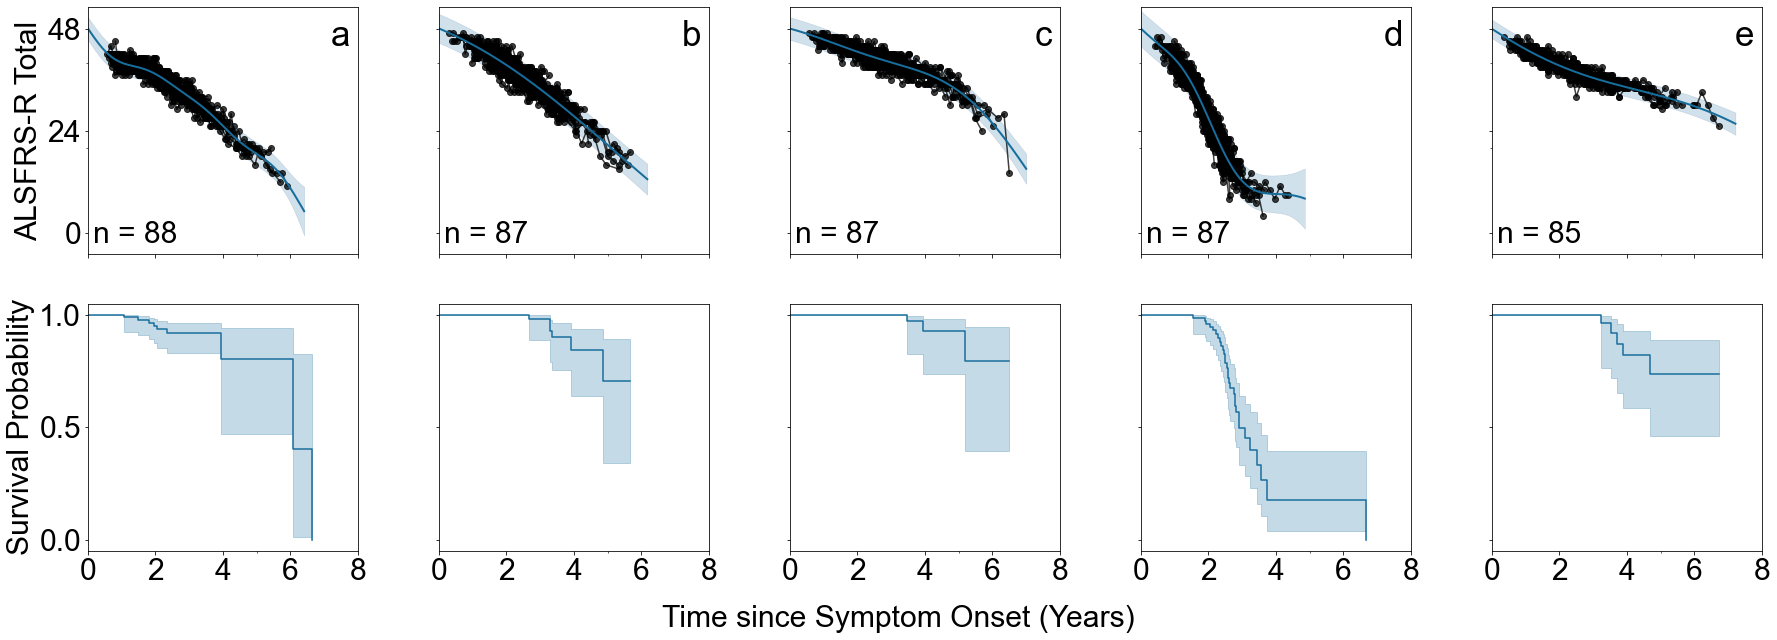

In [8]:
# Plot figure
disp_clust = 5
fig, axs = plt.subplots(2, disp_clust, figsize=(30,10), sharey='row', sharex='col')

nc = len(np.where(cur_model.allocmodel.Nk>0)[0])
idx = np.argsort(-cur_model.allocmodel.Nk)[0:nc]
df_km_counts = pd.DataFrame()

cluster_event_duration_dict = {}

for i, clust in enumerate(idx):
    #Calculate K-M
    cur_kfit, cur_duration, cur_event = calc_surv_km(k=clust, model=cur_model, data=cur_data, df_stat=df_stat_death, 
                        duration_col='disease_duration', event_col='death_event')

    # Store event duration for logrank analysis
    if cur_kfit is not 'err':
        cluster_event_duration_dict[clust]=[cur_duration, cur_event]

    if i < disp_clust:
        k_alph = ascii_lowercase[i]

        # For displayed clusters, plot curves and trajectories:
        ax, cur_num_pat = plot_mogp_by_clust(axs[0,i], cur_model, cur_data, clust, data_col='k', model_col=col_palette[0]) 
        ax = format_panel_axs(ax=ax, alph_lab=k_alph, num_pat=cur_num_pat, k_alph_flag=True, fontsize_numpat=30, fontsize_alph=35)
        ax = cur_kfit.plot(ax=axs[1,i], color=col_palette[0])
        print('Cluster {} Median Survival: {:.2f}'.format(k_alph, cur_kfit.median_survival_time_))
        ax.get_legend().remove()
        _ = ax.set_xlabel('')

        # Generate events table for displayed clusters
        event_table = get_km_counts(cur_kfit, [0,2,4,6,8])
        event_table['clust']=k_alph
        df_km_counts = df_km_counts.append(event_table, ignore_index=True)
    #     ax = add_at_risk_counts(cur_kfit, ax=ax)

_ = axs[0,0].set_ylabel('ALSFRS-R Total')
_ = axs[1,0].set_ylabel('Survival Probability')
_ = fig.text(0.5, 0.05,'Time since Symptom Onset (Years)', va='top', ha='center', transform=fig.transFigure, fontsize=30)

df_km_counts=df_km_counts.set_index('Time').T

# # Save Figure
# plt.savefig('reports/fig_mogp_survival.pdf', bbox_inches='tight')
# df_km_counts.to_csv('reports/fig_km_survival_counts_table.csv')

## Display at-risk table

In [9]:
df_km_counts

Time,0,2,4,6,8,0,2,4,6,8,0,2,4,6,8,0,2,4,6,8,0,2,4,6,8
At Risk,88,69,7,2,0,87,80,13,0,0,87,78,20,2,0,87,72,2,1,0,85,65,14,1,0
Censored,0,15,74,79,79,0,7,69,81,81,0,9,65,82,84,0,12,56,57,57,0,20,67,79,80
Known Deaths,0,4,7,7,9,0,0,5,6,6,0,0,2,3,3,0,3,29,29,30,0,0,4,5,5
clust,a,a,a,a,a,b,b,b,b,b,c,c,c,c,c,d,d,d,d,d,e,e,e,e,e


## Calculate pairwise logrank between MoGP clusters

Calculate logank test between clusters with longer survival durations against shorter (clusters: C | E vs D)
Calculate pairwise logrank between all clusters

In [10]:
idx[:disp_clust]

array([31, 27,  3, 36,  6])

In [11]:
for al in [31, 27, 3,  6]:
    print('Logrank p-val, {} v d: {}'.format(al, calculate_logrank(cluster_event_duration_dict, al, 36)))

Logrank p-val, 31 v d: 6.157095360448555e-06
Logrank p-val, 27 v d: 1.9262778010894664e-11
Logrank p-val, 3 v d: 5.0511351106370554e-14
Logrank p-val, 6 v d: 3.6502906543289427e-10


Calculate logrank test between all clusters

In [12]:
rej, p_adj = pairwise_logrank(cluster_event_duration_dict)

% of clusters that are different with logrank test: 63.39506172839506


## Calculate pairwise logrank for linear kernel model

In [13]:
# Select best MAP model
exp_path = Path('data/model_data/1_alsfrsr_all')

cur_proj = 'proact'
cur_model_path = exp_path / 'results' / 'linear'
cur_data_path = exp_path / 'data_{}_min3_alsfrst.pkl'.format(cur_proj)

cur_model_suffix = 'model_{}_min3_alsfrst'.format(cur_proj)
cur_model = get_map_model(cur_model_path, cur_model_suffix, num_seeds=5)
cur_data = joblib.load(cur_data_path)

nc = len(np.where(cur_model.allocmodel.Nk>0)[0])
idx = np.argsort(-cur_model.allocmodel.Nk)[0:nc]
df_km_counts = pd.DataFrame()

cluster_event_duration_dict_lkm = {}

for i, clust in enumerate(idx):
    #Calculate K-M
    cur_kfit, cur_duration, cur_event = calc_surv_km(k=clust, model=cur_model, data=cur_data, df_stat=df_stat_death, 
                        duration_col='disease_duration', event_col='death_event')

    # Store event duration for logrank analysis
    if cur_kfit is not 'err':
        cluster_event_duration_dict_lkm[clust]=[cur_duration, cur_event]

rej, p_adj = pairwise_logrank(cluster_event_duration_dict_lkm)

best seed: 2, ll -10632.485282565887
% of clusters that are different with logrank test: 50.9926854754441
